In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torchviz import make_dot


@torch.jit.script
def bspline_wavelet(x, omega, alpha):
    return (
        (1 / 6) * F.relu(omega * x) -
        (4 / 3) * F.relu(omega * x - 0.5) +
        (23 / 6) * F.relu(omega * x - 1) -
        (16 / 3) * F.relu(omega * x - 1.5) +
        (23 / 6) * F.relu(omega * x - 2) -
        (4 / 3) * F.relu(omega * x - 2.5) +
        (1 / 6) * F.relu(omega * x - 3)
    ) * alpha


@torch.jit.script
def bspline_wavelet_optimized(x, ms, bs, discs, grad: bool=True):
    y = torch.zeros_like(x).requires_grad_(grad)
    for i in range(6):
        mask = (x <= discs[i+1]) & (x > discs[i])
        y = torch.where(mask, ms[i+1] * x + bs[i+1], y)
    return y


class BSplineWavelet(nn.Module):
    def __init__(self, omega=1., alpha=1.):
        super().__init__()
        self.omega = nn.Parameter(torch.as_tensor(omega, dtype=torch.double), requires_grad=True)
        self.alpha = nn.Parameter(torch.as_tensor(alpha, dtype=torch.double), requires_grad=True)
        self.ms = torch.tensor([0, 1/6, -7/6, 8/3, -8/3, 7/6, -1/6, 0], dtype=torch.double) * self.alpha
        self.bs = torch.tensor([0, 0, 2/3, -19/6, 29/6, -17/6, 1/2, 0], dtype=torch.double) * self.alpha / self.omega
        self.discs = torch.arange(7) / (2 * self.omega)

    def forward(self, x, grad: bool=True):
        output = bspline_wavelet_optimized(x, self.ms, self.bs, self.discs, grad)
        return output * self.omega

In [2]:
# hyperparameters; play around with these
omega = 1
alpha = 1


lower = -1 / omega
upper = 4 / omega
amt = 10**3
x = torch.linspace(lower, upper, amt, dtype=torch.double).requires_grad_(True)
omega, alpha = torch.as_tensor(omega), torch.as_tensor(alpha)


t = time.time()
y = bspline_wavelet(x, omega, alpha)
t = time.time() - t
print(f'BSpline default took {t:.6f} seconds')


mine = BSplineWavelet(omega, alpha)
t = time.time()
y_opt = mine.forward(x, grad=True)
t = time.time() - t
print(f'Optimized version took {t:.6f} seconds')
make_dot(y_opt, params=dict(mine.named_parameters()))


# get Jacobian and Hessian of the output with respect to x
y_opt = mine.forward(x, grad=True)
jacobian = torch.autograd.grad(y_opt.sum(), x, create_graph=True)[0]
print(f"Jacobian of x: {jacobian}")
hessian = torch.zeros(x.shape[0], x.shape[0])
for i in range(x.shape[0]):
    hessian[i] = torch.autograd.grad(jacobian[i], x, retain_graph=True)[0]
print(f"Hessian of x: {hessian}")


torch.autograd.gradcheck(mine.forward, (x, True))   # only checks if the gradients are correct for the given inputs (x)
assert torch.allclose(y, y_opt, atol=1e-4), 'Outputs are not equal'

BSpline default took 0.009640 seconds
Optimized version took 0.039248 seconds
Jacobian of x: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  

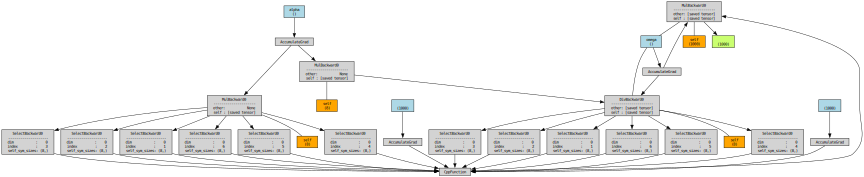

In [3]:
make_dot(y_opt, params=dict(mine.named_parameters()), show_attrs=True, show_saved=True)

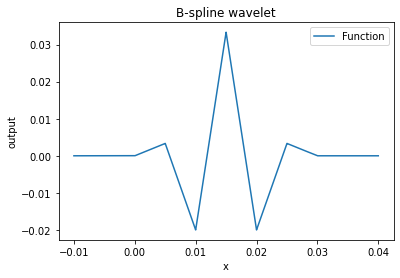

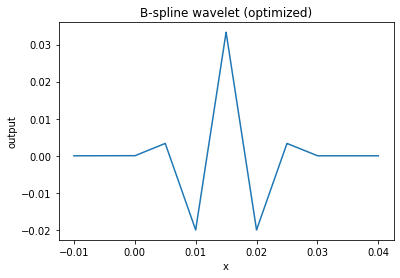

In [4]:
# hyperparameters; play around with these
omega = 100
alpha = 0.04
amt = 10**5


lower = -1 / omega
upper = 4 / omega
x = torch.linspace(lower, upper, amt)
omega, alpha = torch.as_tensor(omega), torch.as_tensor(alpha)


y = bspline_wavelet(x, omega, alpha)
plt.plot(x, y, label='Function')
plt.title('B-spline wavelet')
plt.xlabel('x')
plt.ylabel('output')
plt.legend()
plt.show()


mine = BSplineWavelet(omega, alpha)
y_opt = mine.forward(x, grad=False)
plt.plot(x, y_opt.detach().numpy())
plt.title('B-spline wavelet (optimized)')
plt.xlabel('x')
plt.ylabel('output')
plt.show()

/Users/jjahn/miniconda3/envs/spacestation/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


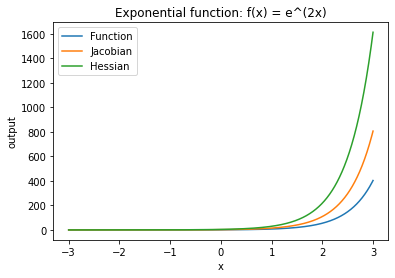

In [5]:
x = torch.linspace(-3, 3, 1000).requires_grad_(True)
y = torch.exp(2*x)
y.sum().backward(create_graph=True)
jacobian = x.grad.clone()
x.grad.zero_()
jacobian.sum().backward()
hessian = x.grad.clone()
x.grad = None

plt.plot(x.detach().numpy(), y.detach().numpy(), label='Function')
plt.plot(x.detach().numpy(), jacobian.detach().numpy(), label='Jacobian')
plt.plot(x.detach().numpy(), hessian.detach().numpy(), label='Hessian')
plt.title('Exponential function: f(x) = e^(2x)')
plt.xlabel('x')
plt.ylabel('output')
plt.legend()
plt.show()